# Analyzing the Titanic dataset
### *by Andrii Zakharov*

***
First things first: importing all the necessary stuff and loading the dataset:

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('titanic_data.csv')

Ok, let's take a first look at it:

In [22]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some variable names are not obvious, so here are the variable descriptions from Kaggle for reference:

|variable name|description|
|---|---|
|survival|        Survival (0 = No; 1 = Yes)|
|pclass|          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
|name|            Name|
|sex|             Sex|
|age|             Age|
|sibsp|           Number of Siblings/Spouses Aboard|
|parch|           Number of Parents/Children Aboard|
|ticket|          Ticket Number|
|fare|            Passenger Fare|
|cabin|           Cabin|
|embarked|        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|

## Hypotheses

It would be interesting to know whether different characteristics of passengers played a role in their survival.

Some hypotheses that I have are:

* Women were more likely to survive than men
* Children were more likely to survive than adults
* Higher passenger class corresponded to higher survival rates

These are all based on my expectation of how such emergency situations play out: Adult men helping women and children first, and higher class passengers having better/faster access to the lifeboats.

Now let's see if my intuition is correct!

## Descriptive part

First I want to check whether any variables contain missing values.

In [23]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

So we have data for 891 passengers, and indeed, there are a bunch of missing data for Age and Cabin and a couple missing values for Embarked.

In the following I will look at a subset of the data, containing the Sex, Age, and Pclass variables as predictors for survival. I will filter out the passengers whose Age is missing from the data. It is the simplest way to deal with missing values, and even though we lose some information (in this case, 891-714=177 observations), the remaining amount should be enough to produce some insights. In a more comprehensive analysis, I might try some imputation method for the missing data (e.g. substitute the missing age values with the mean age, or a more sophisticated model trying to infer passengers' age from other data), but that would be out of the scope of this project. Also, I have doubts that the payoff in this case would be worth the hassle.

At the end, I will take another look at the full dataset and try to connect my findings to other variables that might be of interest.

In [24]:
# take subset of the data, filter out missings
data_subset = data[['Sex', 'Age', 'Pclass', 'Survived']].dropna()
data_subset.count()

Sex         714
Age         714
Pclass      714
Survived    714
dtype: int64

First, let's see how many women and men there were in each class:

In [25]:
counts_table = pd.crosstab(data_subset['Pclass'], data_subset['Sex'])
counts_table

Sex,female,male
Pclass,,
1,85,101
2,74,99
3,102,253


As a plot:

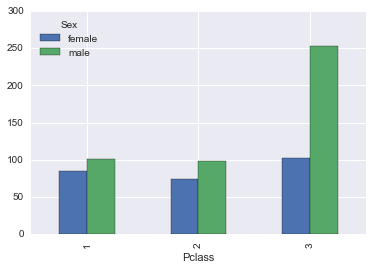

In [26]:
%matplotlib inline

counts_table.plot(kind = 'bar')

The third class had not many more women, but over twice as many men as the first or the second. 

How many of them survived?

In [27]:
survived_table = pd.crosstab(data_subset['Pclass'], [data_subset['Survived'], data_subset['Sex']])
survived_table

Survived      0           1     
Sex      female male female male
Pclass                          
1             3   61     82   40
2             6   84     68   15
3            55  215     47   38

As a percentage:

In [28]:
survived_table[1] / counts_table * 100

Sex,female,male
Pclass,,
1,96.470588,39.603960
2,91.891892,15.151515
3,46.078431,15.019763


Some striking differences there! Let's visualize them by putting the survivors on top of the previous plot of total counts:

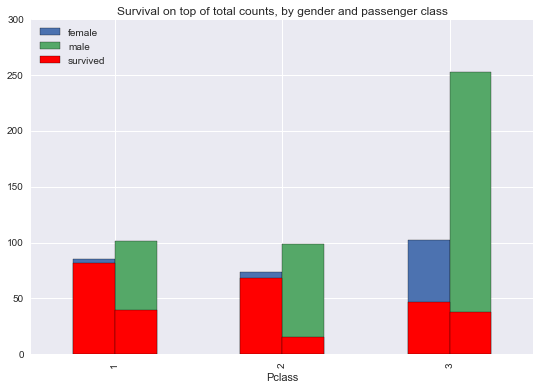

In [29]:
fig, axs = plt.subplots(figsize = (9, 6))

plot1 = counts_table.plot(kind = 'bar', ax = axs, title = "Survival on top of total counts, by gender and passenger class")
plot2 = survived_table[1].plot(kind = 'bar', color = 'r', ax = axs)
plot2.legend(('female', 'male', 'survived'), loc = 2)

There's obviously a massive gender difference, but it's also peculiar how close to all women survived in the first and second class, but only about a half in the third.

The gender difference in survival summarized across class, in percent:

In [30]:
data_subset.groupby('Sex')['Survived'].mean() * 100

Sex
female    75.478927
male      20.529801
Name: Survived, dtype: float64

Could these striking differences in the survival rate have something to do with passengers' age? Let's plot the age distributions by class and gender:

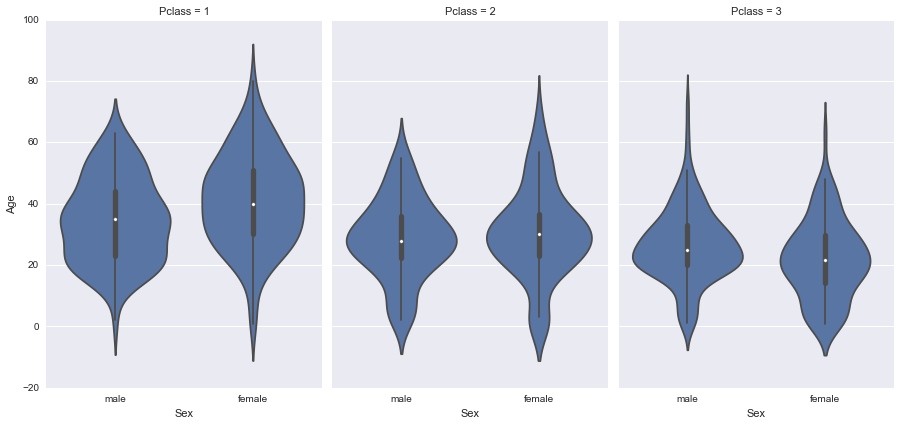

In [31]:
g = sns.FacetGrid(data_subset, col="Pclass", size=6, aspect=.7)
g.map(sns.violinplot, "Sex", "Age")

First class passengers appear to be a little older on average, with women slightly older than men. The reverse is true for the third class, and it is the youngest in general. 

Let's split the distributions by survival.

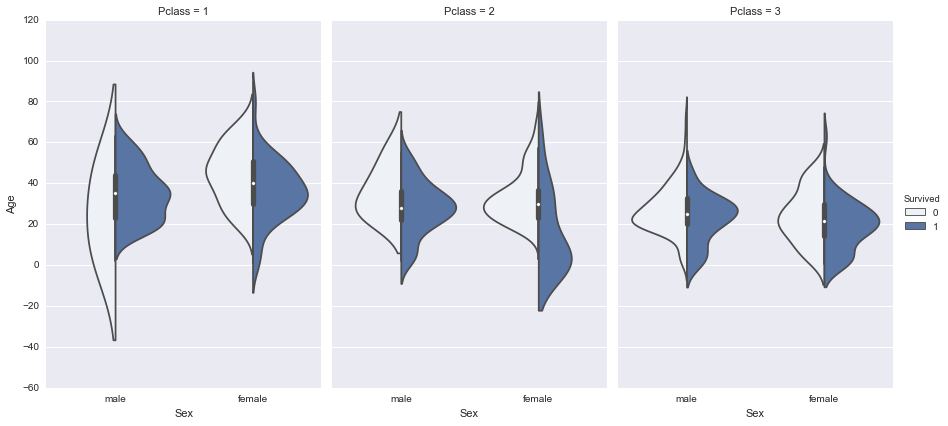

In [32]:
g = sns.FacetGrid(data_subset, col="Pclass", size=6, aspect=.7)
g.map(sns.violinplot, "Sex", "Age", "Survived", split=True).add_legend(title="Survived")

There's a general trend for survival of the younger, and the women (with the exception of men in first class - but it probably is a statistical artifact, as the distribution goes way below zero).

I'd like to introduce the "children" category to the data now, instead of working with the continuous Age further. I do this to somewhat simplify my analysis, as I assume that the relationship between age and survival is not perfectly linear. Of course, this decision is somewhat arbitrary, and I could define it in different ways, but I will go with standard and define "child" as < 18 years of age, and "adult" as >= 18. A simple function will help us to add this new categorical variable.

In [33]:
def child_or_adult(age):
    '''
    Takes numeric age value and returns strings for 
    children and adults, or None if the value is missing
    '''
    if age < 18:
        return 'child'
    elif age >= 18:
        return 'adult'
    else:
        return None

# creates a new categorical variable in the dataframe
data_subset['Child_or_adult'] = data_subset['Age'].apply(child_or_adult)

Here are the survival percentages for children vs. adults:

In [34]:
data_subset.groupby('Child_or_adult')['Survived'].mean() * 100

Child_or_adult
adult    38.103161
child    53.982301
Name: Survived, dtype: float64

Let's now take the survival plotted on top of total counts by gender and class, and split it into children and adults. We will produce two side-by-side plots.

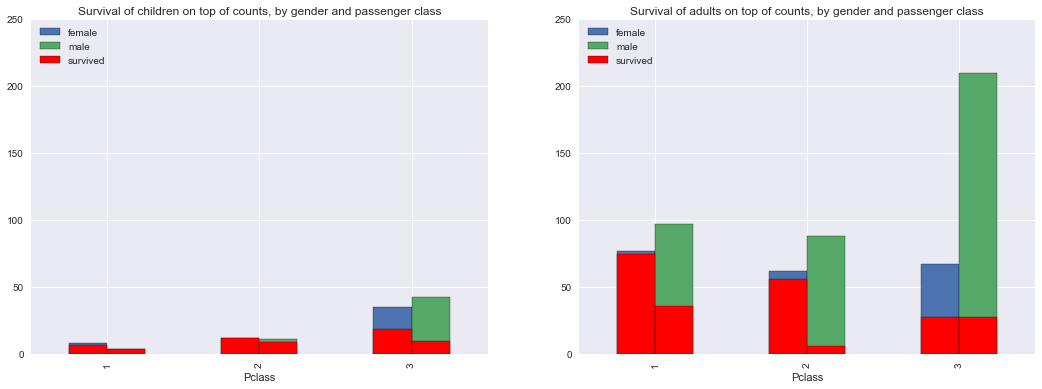

In [35]:
# create data frames and tables for children and adults separately
data_subset_child = data_subset.loc[data_subset['Child_or_adult'] == 'child']
data_subset_adult = data_subset.loc[data_subset['Child_or_adult'] == 'adult']
counts_table_child = pd.crosstab(data_subset_child['Pclass'], data_subset_child['Sex'])
counts_table_adult = pd.crosstab(data_subset_adult['Pclass'], data_subset_adult['Sex'])
survived_table_child = pd.crosstab(data_subset_child['Pclass'], 
                                   [data_subset_child['Survived'], data_subset_child['Sex']])
survived_table_adult = pd.crosstab(data_subset_adult['Pclass'], 
                                   [data_subset_adult['Survived'], data_subset_adult['Sex']])

# plot them on top of each other
fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))

plot_child1 = counts_table_child.plot(kind = 'bar', ax = axs[0], 
                                      title = "Survival of children on top of counts, by gender and passenger class")
plot_child2 = survived_table_child[1].plot(kind = 'bar', color = 'r', ax = axs[0])
plot_child2.legend(('female', 'male', 'survived'), loc = 2)
plot_child1.set_ylim([0, 250])
plot_child2.set_ylim([0, 250])
plot_adult1 = counts_table_adult.plot(kind = 'bar', ax = axs[1], 
                                      title = "Survival of adults on top of counts, by gender and passenger class")
plot_adult2 = survived_table_adult[1].plot(kind = 'bar', color = 'r', ax = axs[1])
plot_adult2.legend(('female', 'male', 'survived'), loc = 2)

We see that not only did almost all adult women from the first and second class escape, but also almost all the children. A comparable number of children escaped from the third class, but here there were over twice as many in total, so the survivors didn't even comprise a half. Still, the survival rate of children was much larger than that of adults in the third class, as evident from the plot on the right.

It is also evident, however, that higher survival rate of children doesn't explain the class or gender differences. Each of these seem to have a main effect.

As an intermediate summary, there appears to be evidence for my intuitive hypotheses so far.

## Inferential part -- what are the odds?

To make sure, I will run a logistic regression with these three predictors (Sex, Child/Adult, Class), to try and get the odds of survival based on each of them.

I will use the statsmodels module. The first step is to dummy-recode the predictors.

In [36]:
import statsmodels.api as sm

# "dummify" the predictor variables
dummy_sex = pd.get_dummies(data_subset['Sex'])
dummy_ch_or_ad = pd.get_dummies(data_subset['Child_or_adult'])
dummy_class = pd.get_dummies(data_subset['Pclass'], prefix='pclass')

print dummy_sex.head()
print dummy_ch_or_ad.head()
print dummy_class.head()

   female  male
0     0.0   1.0
1     1.0   0.0
2     1.0   0.0
3     1.0   0.0
4     0.0   1.0
   adult  child
0    1.0    0.0
1    1.0    0.0
2    1.0    0.0
3    1.0    0.0
4    1.0    0.0
   pclass_1  pclass_2  pclass_3
0       0.0       0.0       1.0
1       1.0       0.0       0.0
2       0.0       0.0       1.0
3       1.0       0.0       0.0
4       0.0       0.0       1.0


Then I create a new dataframe to run the regression on.

"Female", "child" and "pclass_1" levels are left out as baselines. Intercept is added manually as a constant.

In [37]:
data_for_logit = data_subset[['Survived']].join([dummy_sex['male'], dummy_ch_or_ad['adult'], dummy_class.ix[:, 'pclass_2':]])
data_for_logit['intercept'] = 1.0
print data_for_logit.head()

   Survived  male  adult  pclass_2  pclass_3  intercept
0         0   1.0    1.0       0.0       1.0        1.0
1         1   0.0    1.0       0.0       0.0        1.0
2         1   0.0    1.0       0.0       1.0        1.0
3         1   0.0    1.0       0.0       0.0        1.0
4         0   1.0    1.0       0.0       1.0        1.0


Running the logistic regression gives us a nice results table. I'm only interested in coefficients and significance here. The table conveniently provides us with z-transformed coefficients, and the corresponding p-values, allowing for a statement of significance for our findings.

In [38]:
pred_cols = data_for_logit.columns[1:]
logit = sm.Logit(data_for_logit['Survived'], data_for_logit[pred_cols])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.459793
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Tue, 02 Aug 2016   Pseudo R-squ.:                  0.3193
Time:                        18:30:55   Log-Likelihood:                -328.29
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 2.107e-65
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
male          -2.5311      0.206    -12.292      0.000        -2.935    -2.128
adult         -1.0689      0.271     -3.947      0.000        -1.600    -0.538
pclass_2      -1.0102      0.260     -3.879      0.000        -1.521    -0.500
pclass_3      -2.2125      0.251     -8.802      0.000        -2.705    -1.720
intercept      3.3235      0.360      9.229      0.000         2.618     4.029
==============================================================================
"""

Exponentiating the coefficients gives us the odds ratios:

In [39]:
np.exp(result.params)

male          0.079568
adult         0.343371
pclass_2      0.364158
pclass_3      0.109431
intercept    27.758443
dtype: float64

In words, the odds for males to survive were about 92% lower than for females, for adults about 66% lower than for children, and for the passengers in the second and third class about 64% and 90% lower than for those in the first class, respectively.

It must be noted that this model didn't include any interactions, and so the effects for each predictor hold "across all other predictors", i.e. holding their values constant. A more sophisticated model could, for example, include interactions with passenger class, to reflect the previously highlighted difference in survival rates for women in different classes.

As all p-values associated with our z-transformed coefficients are very small (essentially zero in the table), we can conclude that the observed differences in odds are very unlikely to be due to pure chance.

## One more thing

The last thing I would like to look at in this analysis are the cabins. One possible explanation for the different survival rates for passengers in different classes is that their cabins were located in such a way that people in the first class had better access to the lifeboats. I'll look for support of this notion in our cabin data.

I'll assume that the letters in cabin labels are descriptive of their location, not the numbers.
So I will look at all the passengers whose cabin data is available, and compare it with their passenger class.

In [40]:
# get only data for passenger class and cabin for those 204 with cabin data
data2 = data[['Pclass', 'Cabin']].dropna()
print len(data2)

# add a column with only the cabin letters
cab_letters = []
tmp = data2['Cabin']
for val in tmp:
    cab_letters.append(val[0])
data2.loc[:, 'Cab_letters'] = cab_letters

# cross table of passenger class and cabin letters
pd.crosstab(data2['Pclass'], data2['Cab_letters'])

204


Cab_letters,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,15,47,59,29,25,0,0,1
2,0,0,0,4,4,8,0,0
3,0,0,0,0,3,5,4,0


It would seem that cabins A, B, C at least were reserved for the first class passengers. However, one has to be careful here: There's almost no cabin data for the third class, even though most of the passengers were in it - a clear bias. 

I think there is some weak evidence that cabin placement on the ship could be responsible for the difference in survival rates between passenger classes, but it's quite hard to say based only on this biased data. We cannot assume that there were no second and third class passengers in A, B, C cabins. There may be some confounding reason why we only have cabin data for first class here. I would need to learn more about the cabin layout on the Titanic to draw further conclusions.

## Conclusions

I found support for my initial intuitions: Based on our dataset, survival on the Titanic differed by gender, age, and passenger class. In general, higher survival rates were found for women, children, and passengers in higher class. However, there were some interaction effects with class. For instance, almost all women in the first and second class survived, as did almost all children - but less than half of women and children survived in the third class. One possible explanation for this effect could be cabin locations on the ship, but it's hard to tell from this dataset, as we have a relatively small and very biased sample of cabin data. Another partial explanation for the observed differences could be the intuition that men helped women and children escape first. This is tentatively supported by the fact that less than half of the men survived in each class (but again, 40% in 1st, but only 15% in 2nd and 3rd).

In order to provide better explanations, I would need some more background knowledge about the Titanic and its layout, which would allow me to reconstruct missing cabin data. Some qualitative data could help as well, e.g. some eye-witnesses' accounts of the disaster.

I left out some potentially interesting variables in this dataset, like the number of siblings / children / spouse on board, which could potentially help predict individual survival rates (e.g., children with siblings more likely to escape together, or people with their spouses). I'll leave building such a predictive model to further projects.



*** 
### Resources used:

For the logistic regression this great post was very helpful:

<http://blog.yhat.com/posts/logistic-regression-and-python.html>